## TODO

0. Use raw score (output_margin=True)
1. Run on all old labeled data
2. Run on new data
3. Map data on to Fladermaus
4. Collect the full trajectory of scores

## [Jump to analysis](#Analysis)

In [1]:
# %load xgsea.py
import os
import pandas as pd
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.datasets import dump_svmlight_file
import matplotlib.pyplot as plt
import argparse
import random
import pickle

In [2]:
''' notes
max depth 8, num rounds 20 -> .85 r^2
             num rounds 30 -> .87

        + max_delta_step 2 -> .88

fixed data set
                           -> .89
added depthdiff column
                           -> .93
removed id column
                           -> .89
gamma=.7 parameter added
                           -> .89 (.002 increase)

jamstec
'eta': 1,
 'max_delta_step': 1,
 'max_depth': 11,
 'nthread': 4,
 'objective': 'binary:logistic',
 'silent': 1}              -> .87


'''

def read(f):
    # names = ['long','lat','depth','sigma_h','sigma_d','source_id','pred_depth','dens20', 'dens60','gravity','age','rate','sed thick', 'roughness', 'dens10']
    
    print('reading in data')
    #data = pd.read_csv(f, delimiter='\s+', names=names)
    data = pd.read_hdf(f)

    # return make_xgstuff(clean(data))
    # return clean(data)
    return data

def clean(data):
    y = 'sigma_d'
    # replace na with mean
    print('cleaning data')
    data.fillna(data.mean(), inplace=True)
    
    # change sigma_d to boolean, new method using list comprehension
    data[y] = [x == 9999 for x in data[y]]

    # create depthdiff column
    data['depthdiff'] = data['depth'] - data['pred_depth']

    # cleaner way to drop columns
    return data.drop(['depth', 'source_id'], axis=1)

def make_xgstuff(data):
    y = 'sigma_d'
    # split
    train, test = train_test_split(data, test_size=.3)

    # defines independent column names for test set
    x = [x != y for x in list(data.columns)]
    
    # splits dataframe into x and y vectors
    xtest = test.ix[:,x]
    ytest = test[y]

    xtrain = train.ix[:,x]
    ytrain = train[y]

    # convert to xgb data structures
    xgtrain = xgb.DMatrix(xtrain.values, ytrain.values, 
                          feature_names=list(xtrain.columns))
    xgtest = xgb.DMatrix(xtest.values, feature_names=list(xtrain.columns))
    
    return xgtrain, xgtest, ytest

def stream_dump(data, file_path):
    max_bytes = 2**31 - 1
    bytes_out = pickle.dumps(data, protocol=4)
    n_bytes = len(bytes_out)
    print("Data size:", n_bytes)

    with open(file_path, 'wb') as f_out:
        for idx in range(0, n_bytes, max_bytes):
            f_out.write(bytes_out[idx:idx+max_bytes])


def stream_read(file_path):
    max_bytes = 2**31 - 1
    bytes_in = bytearray(0)
    input_size = os.path.getsize(file_path)
    with open(file_path, 'rb') as f_in:
        for _ in range(0, input_size, max_bytes):
            bytes_in += f_in.read(max_bytes)
    return pickle.loads(bytes_in)


def dump_pickle(uncleaned_data):
    """
    Can't use normal pickle dump because of the following bug:
        Bug in OSX: [issue 24658](https://bugs.python.org/issue24658)
    """
    y = 'sigma_d'

    # replace na with mean
    print('cleaning data')
    uncleaned_data.fillna(uncleaned_data.mean(), inplace=True)
    data = uncleaned_data

    # change sigma_d to boolean, new method using list comprehension
    data[y] = [x == 9999 for x in data[y]]

    # create depthdiff column
    data['depthdiff'] = data['depth'] - data['pred_depth']

    # cleaner way to drop columns
    data.drop(['depth', 'source_id'], axis=1, inplace=True)

    # split
    train, test = train_test_split(data, test_size=.3)

    # defines independent column names for test set
    x = [x != y for x in list(data.columns)]

    # splits dataframe into x and y vectors
    xtest = test.ix[:,x]
    ytest = test[y]

    xtrain = train.ix[:,x]
    ytrain = train[y]

    stream_dump(ytest, xtest, "test.pkl")
    stream_dump(ytrain, xtrain, "train.pkl")


def dump_libsvm(input_filename, output_filename):
    y, x = stream_read(input_filename)
    filename = os.path.join(base_path, output_filename)
    dump_svmlight_file(x.values, y.values, filename, zero_based=False)

In [4]:
ls -lrht /Users/btea/hdfs

total 126294744
-rw-r--r--  1 btea  staff   4.9G Oct 25 11:42 sio.hdf5
-rw-r--r--  1 btea  staff   9.5G Nov 27 13:18 jamstec.hdf5
-rw-r--r--  1 btea  staff   5.5G Dec  1 12:58 geodas.hdf5
-rw-r--r--  1 btea  staff   671M Dec  1 12:59 nga.hdf5
-rw-r--r--  1 btea  staff    16G Dec  1 13:44 ngdc.hdf5
-rw-r--r--  1 btea  staff   1.6G Dec 10 19:54 ngdc_small.hdf5
-rw-r--r--  1 btea  staff    15G Feb 20 14:11 train-ngdc.libsvm
-rw-r--r--  1 btea  staff   6.6G Feb 20 15:28 test-ngdc.libsvm


In [4]:
# if __name__ == '__main__':
# argument parser

"""
parser = argparse.ArgumentParser(description = 
    'generates xgb model from seafloor dataset')

parser.add_argument('dataset',
                    help = 'hdf dataset to model')

parser.add_argument('name', 
                    help = 'name of dataset')

arg = parser.parse_args()
"""

base_path = "/Users/btea/hdfs/"
dataset = "ngdc"
arg = {}
arg["dataset"] = os.path.join(base_path, "{}.hdf5".format(dataset))
arg["name"] = "nga"

# housekeeping
random.seed(1105)

# xgtrain, xgtest, ytest = read(arg["dataset"])
data = read(arg["dataset"])
dump_pickle(data)

reading in data


In [6]:
# Might need to restart the kernel at this point to clear up the memory
base_path = "/Users/btea/hdfs/"
dataset = "ngdc"
if False:
    dump_libsvm("train.pkl", "train-{}.libsvm".format(dataset))
    dump_libsvm("test.pkl", "test-{}.libsvm".format(dataset))

xgtrain = xgb.DMatrix(
    os.path.join(base_path, "train-{}.libsvm".format(dataset))
    + "#dtrain.cache")
xgtest = xgb.DMatrix(
    os.path.join(base_path, "test-{}.libsvm".format(dataset)))
#     + "#dtest.cache")

In [3]:
# parameters
param = {
    'jam': { # works well with geodas, sio also
        'max_depth':11, 
        'eta':1, 
        'silent':1, 
        'objective':'binary:logistic',
        'nthread':6,
        'max_delta_step':1
    },
    'nga': {
        'max_depth':10,
        'max_delta_step':2,
        'gamma':.7,
        'eta':1, 
        'objective':'binary:logistic',
        'nthread':4,
        'silent':1
    },
    'sio': {
        'max_depth':20,
        'eta':1,
        'silent':1,
        'objective':'binary:logistic',
        'nthread':6,
        'max_delta_step':1
    },
}

param['ngdc'] = {**param['jam'], 'max_depth':8}

num_round = 100

In [9]:
from time import time

# train
print('training')

arg = {"name": dataset}
if arg["name"] not in param:
    print('no params found for dataset, using jamstec as default')
    name = 'jam'
else:
    name = arg["name"]
print("Options for " + name + " is selected.")

timer = time()
bst = xgb.train(param[name], xgtrain, num_round)
print("Training takes %.2f seconds" % (time() - timer))

training
Options for ngdc is selected.
Training takes 3420.78 seconds


In [10]:
bst.save_model("bst.model")

In [4]:
bst = xgb.Booster({"nthread": 4})
bst.load_model("bst.model")

In [8]:
base_path = "/Users/btea/hdfs/"
dataset = "ngdc"
ytest, _ = stream_read("test.pkl")
xgtest = xgb.DMatrix(
    os.path.join(base_path, "test-{}.libsvm".format(dataset)))

In [9]:
# Large data
# test
#print('calculating r2')
num_round = 100
all_preds = []
for k in range(1, num_round + 1):
    all_preds.append(bst.predict(xgtest, ntree_limit=k))
preds = bst.predict(xgtest)
all_preds = np.array(all_preds)

In [12]:
# print error
get_err = lambda preds: sum(1 for pred, actual in zip(preds, ytest) if (pred>.5)!=actual) / len(preds)
errs = list(map(get_err, all_preds))
err = get_err(preds)
print('error: {:.2%}'.format(err))

# roc
all_auc = [metrics.roc_auc_score(ytest, pred) for pred in all_preds]
print(metrics.roc_auc_score(ytest, preds))

error: 1.01%
0.996789929798


In [10]:
# test
#print('calculating r2')
path = []
for k in range(1, num_round + 1):
    path.append(bst.predict(xgtest, output_margin=True, ntree_limit=k))
path = np.array(path).T

In [5]:
import pickle
import numpy as np

if False:
    pickle.dump((ytest, errs, all_auc), open("prediction-large.pkl", "wb"))
    np.save("all_preds", all_preds)
    np.save("path", path)
else:
    with open("prediction-large.pkl", "rb") as f:
        (ytest, errs, all_auc) = pickle.load(f)
    all_preds = np.load("all_preds.npy")
    path = np.load("path.npy")
    preds = all_preds[-1]

# Analysis

In [11]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from sklearn import metrics

In [8]:
ytest_array = np.array(ytest)
no_ytest_array = np.logical_not(ytest_array)
npos, nneg = preds[ytest_array].shape[0], preds[no_ytest_array].shape[0]
base_err = max(npos, nneg) / (npos + nneg)
print(
    "Number of positive examples: {}\n"
    "Number of negative examples: {}\n"
    "Base line accuracy: {}".format(
        npos, nneg, base_err
    )
)

Number of positive examples: 1913688
Number of negative examples: 38370795
Base line accuracy: 0.9524956544682477


### Performance

Text(0.5,0,'Iteration')

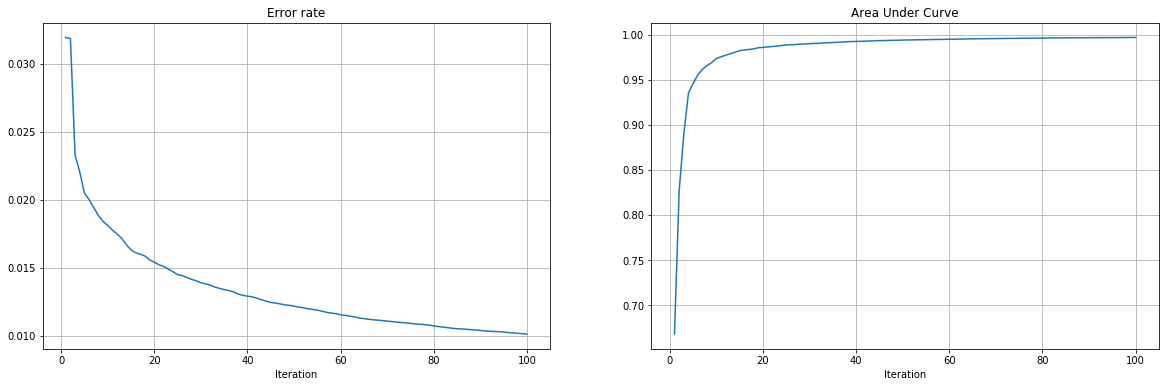

In [9]:
plt.figure(figsize=(20, 6))
plt.subplot(121)
plt.plot(range(1, len(errs) + 1), errs)
plt.grid()
plt.title("Error rate")
plt.xlabel("Iteration")
plt.subplot(122)
plt.plot(range(1, len(errs) + 1), all_auc)
plt.grid()
plt.title("Area Under Curve")
plt.xlabel("Iteration")

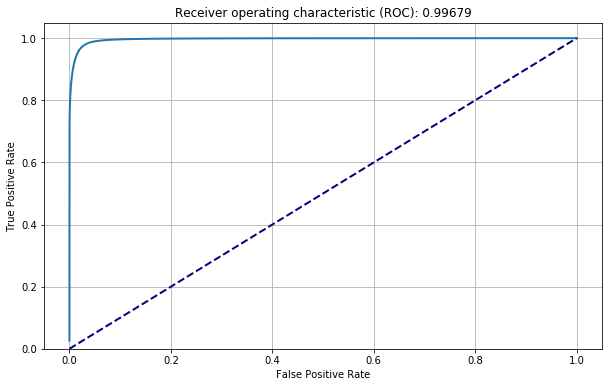

In [12]:
auc = metrics.roc_auc_score(ytest, all_preds[-1])
fpr, tpr, _ = metrics.roc_curve(ytest, all_preds[-1])

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, lw=2, label="ROC curve (area = %0.5f)" % auc)
plt.plot([0, 1], [0, 1], lw=2, color='navy', linestyle='--')
# plt.xlim([0.0, 0.02])
plt.ylim([0.0, 1.05])
# plt.yscale("log")
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC): %.5f' % auc)
plt.show()

### Score and margin distribution

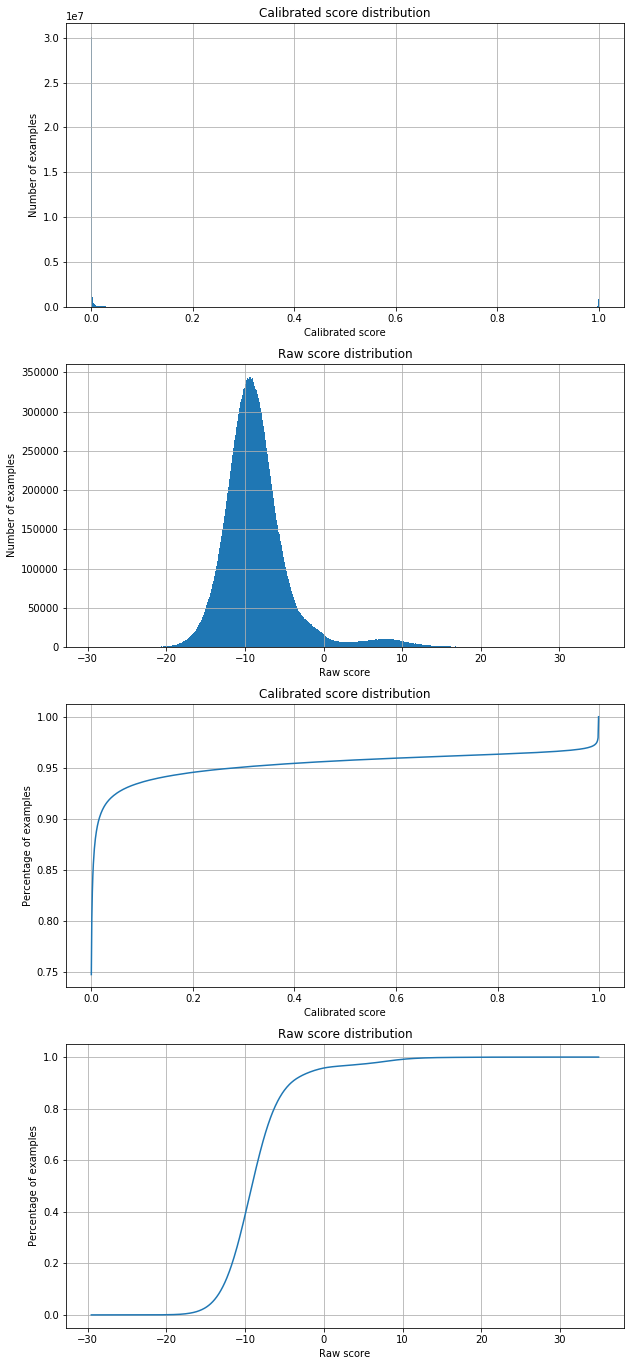

In [13]:
def plt_dist(preds, path, label=None):
    plt.subplot(411)
    preds_vol, preds_bins, _ = plt.hist(preds, bins=1000, label=label)
    if label:
        plt.legend()
    plt.grid()
    plt.title("Calibrated score distribution")
    plt.ylabel("Number of examples")
    plt.xlabel("Calibrated score")
    plt.subplot(412)
    path_vol, path_bins, _ = plt.hist(path, bins=1000, label=label)
    if label:
        plt.legend()
    plt.grid()
    plt.title("Raw score distribution")
    plt.ylabel("Number of examples")
    plt.xlabel("Raw score")

    if type(preds_vol) is not list:
        preds_vol = [preds_vol]
        path_vol = [path_vol]
    if label is None:
        label = [None]

    plt.subplot(413)
    for idx, lab in enumerate(label):
        cum_preds_vol = np.cumsum(preds_vol[idx])
        cum_preds_vol = cum_preds_vol / cum_preds_vol[-1]
        preds_bin = preds_bins[:-1]
        if lab == "negative":
            cum_preds_vol = 1 - cum_preds_vol
        plt.plot(preds_bin, cum_preds_vol, label=lab)
    if label:
        plt.legend()
    plt.grid()
    plt.title("Calibrated score distribution")
    plt.ylabel("Percentage of examples")
    plt.xlabel("Calibrated score")

    plt.subplot(414)
    for idx, lab in enumerate(label):
        cum_path_vol = np.cumsum(path_vol[idx])
        cum_path_vol = cum_path_vol / cum_path_vol[-1]
        path_bin = path_bins[:-1]
        if lab == "negative":
            cum_path_vol = 1 - cum_path_vol
        plt.plot(path_bin, cum_path_vol, label=lab)
    if label:
        plt.legend()
    plt.grid()
    plt.title("Raw score distribution")
    plt.ylabel("Percentage of examples")
    plt.xlabel("Raw score")
    return (label, path_vol, path_bins)


plt.figure(figsize=(10, 24))
plt_dist(all_preds[-1], path[:, -1]);

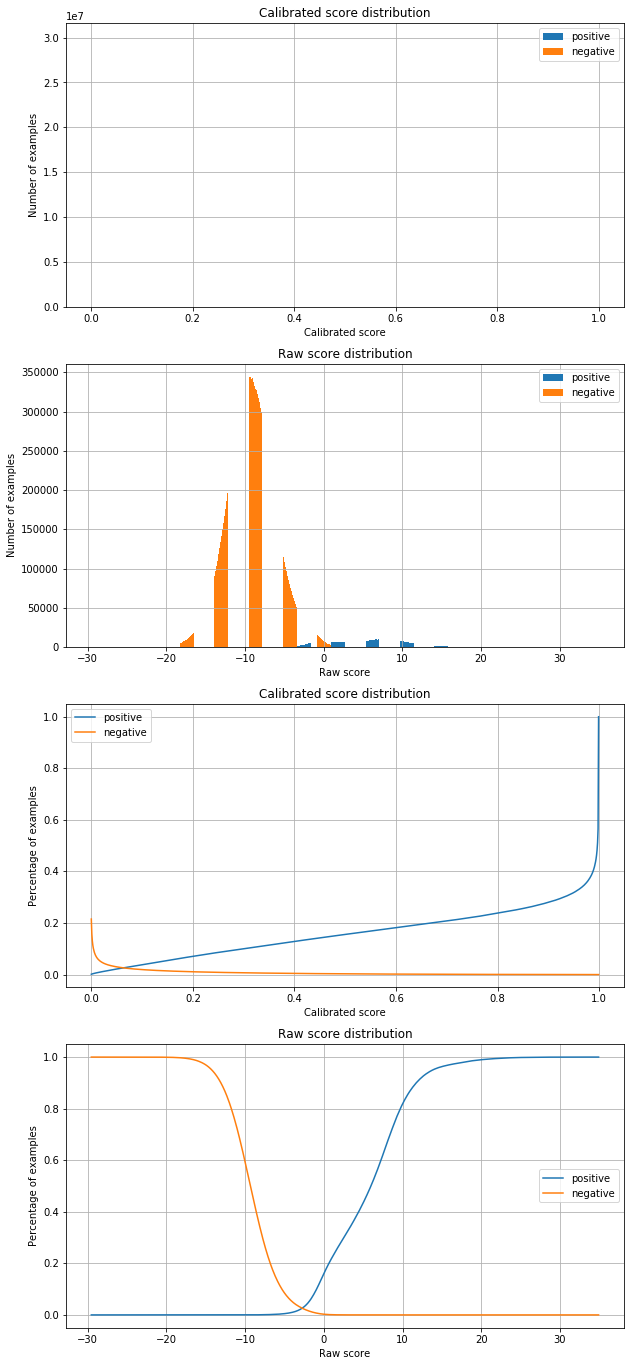

In [15]:
plt.figure(figsize=(10, 24))
(label, path_vol, path_bins) = plt_dist(
    (all_preds[-1][ytest_array], all_preds[-1][no_ytest_array]),
    (path[ytest_array, -1], path[no_ytest_array, -1]),
    label=["positive", "negative"]
)

(-15, 15)

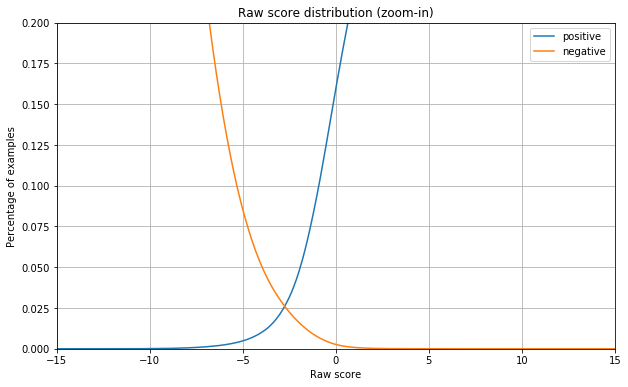

In [21]:
plt.figure(figsize=(10, 6))
for idx, lab in enumerate(label):
    cum_path_vol = np.cumsum(path_vol[idx])
    cum_path_vol = cum_path_vol / cum_path_vol[-1]
    path_bin = path_bins[:-1]
    if lab == "negative":
        cum_path_vol = 1 - cum_path_vol
    plt.plot(path_bin, cum_path_vol, label=lab)
if label:
    plt.legend()
plt.grid()
plt.title("Raw score distribution (zoom-in)")
plt.ylabel("Percentage of examples")
plt.xlabel("Raw score")
plt.ylim(0.0, 0.2)
plt.xlim(-15, 15)

## Trajectory of scores

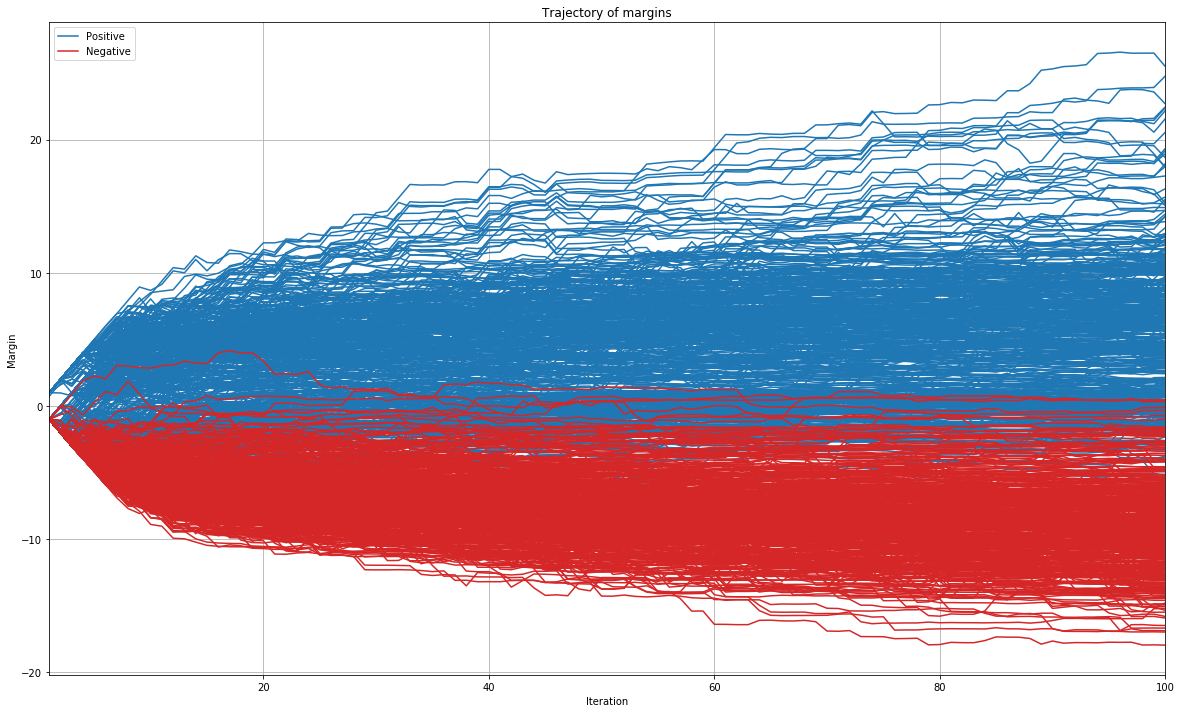

In [31]:
T = 500

num_trees = list(range(1, path.shape[1] + 1))
positive_c = "#1f77b4"
negative_c = "#d62728"
plt.figure(figsize=(20, 12))
plt.plot(num_trees, path[ytest_array][:T].T, c=positive_c)
plt.plot(num_trees, path[ytest_array][T].T, c=positive_c, label="Positive")
plt.plot(num_trees, path[no_ytest_array][:T].T, c=negative_c)
plt.plot(num_trees, path[no_ytest_array][T].T, c=negative_c, label="Negative")
plt.title("Trajectory of margins")
plt.xlabel("Iteration")
plt.ylabel("Margin")
plt.xlim(1, path.shape[1])
plt.grid()
plt.legend();